In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Patients_data_BDA") \
    .getOrCreate()
spark


 Load a Dataset

In [ ]:
df = spark.read.csv(r"/content/drive/MyDrive/Patients_Data.csv", header=True, inferSchema=True)
df.printSchema()
df.show()


root
 |-- PatientID: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- HeightInMeters: double (nullable = true)
 |-- WeightInKilograms: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- HadHeartAttack: integer (nullable = true)
 |-- HadAngina: integer (nullable = true)
 |-- HadStroke: integer (nullable = true)
 |-- HadAsthma: integer (nullable = true)
 |-- HadSkinCancer: integer (nullable = true)
 |-- HadCOPD: integer (nullable = true)
 |-- HadDepressiveDisorder: integer (nullable = true)
 |-- HadKidneyDisease: integer (nullable = true)
 |-- HadArthritis: integer (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: integer (nullable = true)
 |-- BlindOrVisionDifficulty: integer (nullable = true)
 |-- DifficultyConcentrating: integer (nullable = true)
 |-- DifficultyWalking: integer (nullable = true)

In [ ]:
df.printSchema()

root
 |-- PatientID: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- HeightInMeters: double (nullable = true)
 |-- WeightInKilograms: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- HadHeartAttack: integer (nullable = true)
 |-- HadAngina: integer (nullable = true)
 |-- HadStroke: integer (nullable = true)
 |-- HadAsthma: integer (nullable = true)
 |-- HadSkinCancer: integer (nullable = true)
 |-- HadCOPD: integer (nullable = true)
 |-- HadDepressiveDisorder: integer (nullable = true)
 |-- HadKidneyDisease: integer (nullable = true)
 |-- HadArthritis: integer (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: integer (nullable = true)
 |-- BlindOrVisionDifficulty: integer (nullable = true)
 |-- DifficultyConcentrating: integer (nullable = true)
 |-- DifficultyWalking: integer (nullable = true)

MISSING VALUES

In [ ]:
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+---------+-----+---+-------------+-----------+--------------+-----------------+---+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+------------+---------------+---------+---------------------+---------------+----------+------------+-------------+-----------------+----------------+--------+
|PatientID|State|Sex|GeneralHealth|AgeCategory|HeightInMeters|WeightInKilograms|BMI|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressingBathing|DifficultyErrands|SmokerStatus|ECigaretteUsage|ChestScan|RaceEthnicityCategory|AlcoholDrinkers|HIVTesting|FluVaxLast12|PneumoVaxEver|TetanusLast10Tdap|HighRiskLastYear|

Handling Outliers


In [ ]:
def remove_outliers(df, column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

def count_outliers(df, column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return outliers.count()
numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double', 'float')]
print("Outliers before removal:")
for col_name in numerical_columns:
    outlier_count = count_outliers(df, col_name)
    print(f"Column: {col_name}, Outliers: {outlier_count}")

for col_name in numerical_columns:
    df = remove_outliers(df, col_name)

print("\nOutliers after removal:")
for col_name in numerical_columns:
    outlier_count = count_outliers(df, col_name)
    print(f"Column: {col_name}, Outliers: {outlier_count}")

Outliers before removal:
Column: PatientID, Outliers: 0
Column: HeightInMeters, Outliers: 813
Column: WeightInKilograms, Outliers: 5976
Column: BMI, Outliers: 9982
Column: HadHeartAttack, Outliers: 13201
Column: HadAngina, Outliers: 14617
Column: HadStroke, Outliers: 9928
Column: HadAsthma, Outliers: 35292
Column: HadSkinCancer, Outliers: 20252
Column: HadCOPD, Outliers: 18602
Column: HadDepressiveDisorder, Outliers: 48896
Column: HadKidneyDisease, Outliers: 11029
Column: HadArthritis, Outliers: 0
Column: DeafOrHardOfHearing, Outliers: 20540
Column: BlindOrVisionDifficulty, Outliers: 11987
Column: DifficultyConcentrating, Outliers: 25501
Column: DifficultyWalking, Outliers: 35391
Column: DifficultyDressingBathing, Outliers: 8204
Column: DifficultyErrands, Outliers: 16056
Column: ChestScan, Outliers: 0
Column: AlcoholDrinkers, Outliers: 0
Column: HIVTesting, Outliers: 0
Column: FluVaxLast12, Outliers: 0
Column: PneumoVaxEver, Outliers: 0
Column: HighRiskLastYear, Outliers: 10176
Column:

In [ ]:
print(f"No of Rows: {df.count()}")
print(f"No of Columns: {len(df.columns)}")

No of Rows: 237630
No of Columns: 35


# EDA


EDA

In [ ]:
df.describe()


DataFrame[summary: string, PatientID: string, State: string, Sex: string, GeneralHealth: string, AgeCategory: string, HeightInMeters: string, WeightInKilograms: string, BMI: string, HadHeartAttack: string, HadAngina: string, HadStroke: string, HadAsthma: string, HadSkinCancer: string, HadCOPD: string, HadDepressiveDisorder: string, HadKidneyDisease: string, HadArthritis: string, HadDiabetes: string, DeafOrHardOfHearing: string, BlindOrVisionDifficulty: string, DifficultyConcentrating: string, DifficultyWalking: string, DifficultyDressingBathing: string, DifficultyErrands: string, SmokerStatus: string, ECigaretteUsage: string, ChestScan: string, RaceEthnicityCategory: string, AlcoholDrinkers: string, HIVTesting: string, FluVaxLast12: string, PneumoVaxEver: string, TetanusLast10Tdap: string, HighRiskLastYear: string, CovidPos: string]

In [ ]:
from pyspark.sql.functions import format_number
df = df.withColumn("BMI", format_number("BMI", 2))

In [ ]:
string_columns = [item[0] for item in df.dtypes if item[1].startswith('string')]

In [ ]:
from pyspark.sql.functions import countDistinct, count

for col in string_columns:
  summary = df.agg(
            countDistinct(col).alias("unique_count"),
            count(col).alias("total_count")).collect()[0]

print(f"Summary for column '{col}':")
print(f"  Unique values: {summary['unique_count']}")
print(f"  Total count: {summary['total_count']}")


Summary for column 'TetanusLast10Tdap':
  Unique values: 4
  Total count: 237630


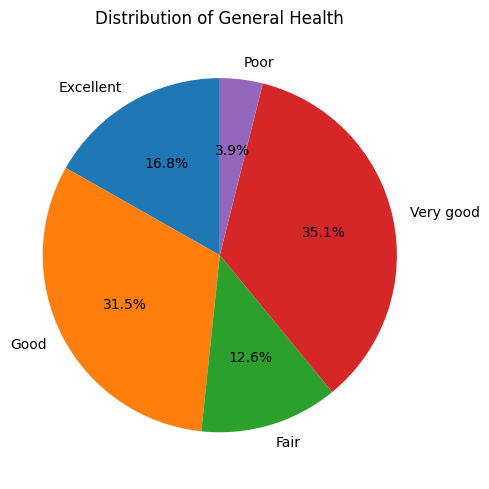

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


general_health_counts_pd = df.groupBy("GeneralHealth").count().toPandas()


plt.figure(figsize=(5, 5))
plt.pie(general_health_counts_pd["count"], labels=general_health_counts_pd["GeneralHealth"], autopct='%1.1f%%', startangle=90)
plt.title("Distribution of General Health")
plt.axis('equal')
plt.tight_layout()
plt.show()

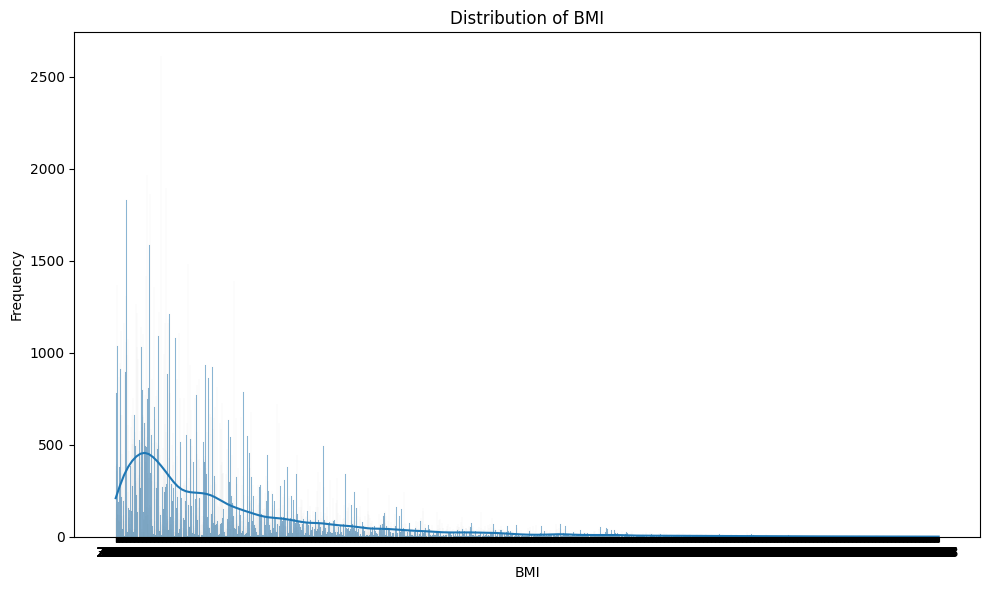

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


bmi_pd = df.select("BMI").toPandas()


plt.figure(figsize=(10, 6))
sns.histplot(bmi_pd["BMI"], bins=20, kde=True)
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Distribution of BMI")
plt.tight_layout()
plt.show()

In [ ]:
df.select("State", "AgeCategory").distinct().show()


+--------------------+------------+
|               State| AgeCategory|
+--------------------+------------+
|             Alabama|Age 25 to 29|
|              Alaska|Age 65 to 69|
|District of Columbia|Age 50 to 54|
|            Kentucky|Age 60 to 64|
|              Nevada|Age 50 to 54|
|           Wisconsin|Age 25 to 29|
|             Georgia|Age 40 to 44|
|       Massachusetts|Age 25 to 29|
|         Mississippi|Age 65 to 69|
|            Kentucky|Age 75 to 79|
|           Minnesota|Age 40 to 44|
|             Montana|Age 45 to 49|
|             Arizona|Age 70 to 74|
|            Virginia|Age 65 to 69|
|         Connecticut|Age 25 to 29|
|               Texas|Age 30 to 34|
|            Illinois|Age 70 to 74|
|              Kansas|Age 18 to 24|
|District of Columbia|Age 45 to 49|
|              Kansas|Age 40 to 44|
+--------------------+------------+
only showing top 20 rows



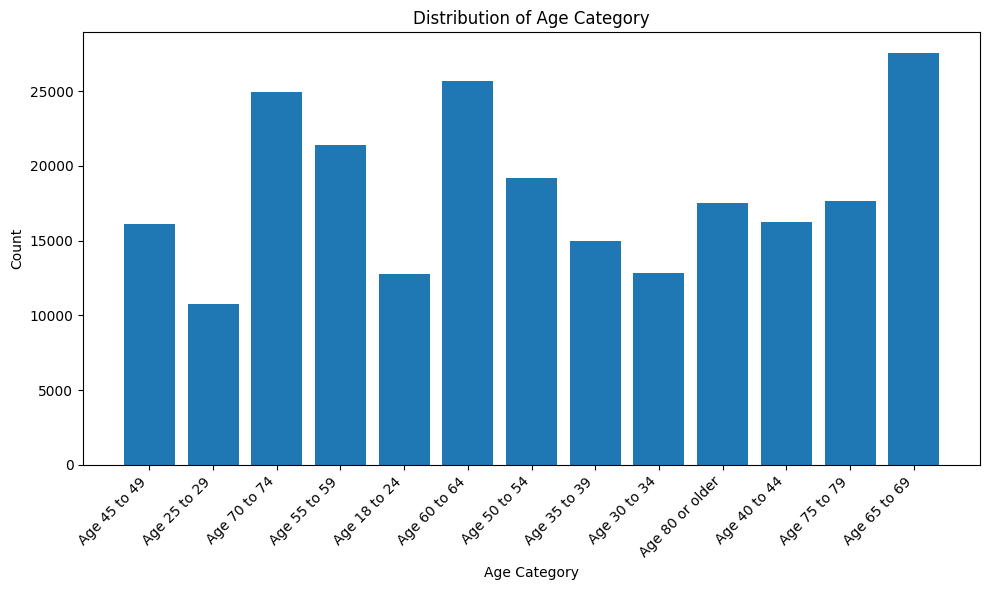

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

age_category_counts_pd = df.groupBy("AgeCategory").count().toPandas()


plt.figure(figsize=(10, 6))
plt.bar(age_category_counts_pd["AgeCategory"], age_category_counts_pd["count"])
plt.xlabel("Age Category")
plt.ylabel("Count")
plt.title("Distribution of Age Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
numerical_columns = ['PatientId','AgeCategory','HeightInMeters','WeightInKilograms','BMI','HadHeartAttack','HadAngina','HadStroke','HadAsthma','HadSkinCancer','HadCOPD','HadDepressiveDisorder','HadKidneyDisease','HadArthritis','DeafOrHardOfHearing','BlindOrVisionDifficulty',
                     'DifficultyConcentrating','DifficultyWalking','DifficultyDressingBathing','DifficultyErrands','ChestScan','AlcoholDrinkers','HIVTesting','FluVaxLast12','PneumoVaxEver','HighRiskLastYear','CovidPos']


In [ ]:
import pyspark.sql.functions as F

def check_outliers(df, column_name):
    stats = df.select(F.min(column_name), F.max(column_name)).collect()
    print(f"{column_name} range: {stats[0][0]} to {stats[0][1]}")

In [ ]:
rdd = df.rdd

# ACTION TRANSFORMATION

RDD TRANSFORMATIONS

 filter() — Extract patients who had a heart attack.

In [ ]:
heart_attack_rdd = rdd.filter(lambda row: row["HadHeartAttack"] == 1)
print(heart_attack_rdd.collect())


[]


map() funtion to Compute a new column for weight category based on BMI

In [ ]:
def categorize_bmi(row):

    bmi = float(row["BMI"])
    category = (
        "Underweight" if bmi < 18.5 else
        "Normal weight" if 18.5 <= bmi < 25 else
        "Overweight" if 25 <= bmi < 30 else
        "Obese"
    )
    return row + (category,)

rdd_with_bmi_category = rdd.map(categorize_bmi)
print(rdd_with_bmi_category.take(10))

[(1, 'Alabama', 'Female', 'Fair', 'Age 75 to 79', 1.629999995, 84.81999969, '32.10', 0, 1, 0, 1, 1, 0, 0, 0, 1, 'Yes', 0, 0, 0, 1, 0, 0, 'Former smoker', 'Never used e-cigarettes in my entire life', 1, 'White only, Non-Hispanic', 0, 0, 0, 1, 'No, did not receive any tetanus shot in the past 10 years', 0, 1, 'Obese'), (2, 'Alabama', 'Female', 'Very good', 'Age 65 to 69', 1.600000024, 71.66999817, '27.99', 0, 0, 0, 0, 0, 0, 0, 0, 1, 'No', 0, 0, 0, 0, 0, 0, 'Former smoker', 'Never used e-cigarettes in my entire life', 0, 'White only, Non-Hispanic', 0, 0, 1, 1, 'Yes, received Tdap', 0, 0, 'Overweight'), (3, 'Alabama', 'Male', 'Excellent', 'Age 60 to 64', 1.779999971, 71.20999908, '22.53', 0, 0, 0, 0, 0, 0, 0, 0, 0, 'No', 0, 0, 0, 0, 0, 0, 'Never smoked', 'Never used e-cigarettes in my entire life', 0, 'White only, Non-Hispanic', 1, 0, 0, 0, 'Yes, received tetanus shot but not sure what type', 0, 0, 'Normal weight'), (4, 'Alabama', 'Male', 'Very good', 'Age 70 to 74', 1.779999971, 95.25, '3

 distinct() — Find unique states in the dataset.

In [ ]:
unique_states = rdd.map(lambda row: row["State"]).distinct()
print(unique_states.collect())


['Alabama', 'Connecticut', 'Colorado', 'Hawaii', 'Idaho', 'Indiana', 'Kansas', 'New Jersey', 'Nebraska', 'New York', 'Oklahoma', 'Washington', 'Illinois', 'Virginia', 'Louisiana', 'Wisconsin', 'Mississippi', 'Missouri', 'Nevada', 'New Hampshire', 'North Carolina', 'Oregon', 'South Dakota', 'Tennessee', 'Wyoming', 'Guam', 'Virgin Islands', 'Alaska', 'Arizona', 'California', 'Arkansas', 'Delaware', 'Florida', 'Georgia', 'District of Columbia', 'Iowa', 'Maryland', 'Minnesota', 'Montana', 'Ohio', 'Texas', 'Vermont', 'Utah', 'West Virginia', 'Massachusetts', 'Kentucky', 'Maine', 'Michigan', 'New Mexico', 'South Carolina', 'North Dakota', 'Pennsylvania', 'Rhode Island', 'Puerto Rico']


reduceby

In [ ]:
age_category_count = rdd.map(lambda row: (row["AgeCategory"], 1)).reduceByKey(lambda x, y: x + y)
sorted_age_category_count = age_category_count.sortBy(lambda x: x[1], ascending=False)


print(sorted_age_category_count.collect())



[('Age 65 to 69', 27547), ('Age 60 to 64', 25685), ('Age 70 to 74', 24946), ('Age 55 to 59', 21422), ('Age 50 to 54', 19154), ('Age 75 to 79', 17679), ('Age 80 or older', 17544), ('Age 40 to 44', 16228), ('Age 45 to 49', 16095), ('Age 35 to 39', 14982), ('Age 30 to 34', 12825), ('Age 18 to 24', 12777), ('Age 25 to 29', 10746)]


cartesian

In [ ]:
gender_rdd = rdd.map(lambda row: row["Sex"]).distinct()
health_rdd = rdd.map(lambda row: row["GeneralHealth"]).distinct()
cartesian_rdd = gender_rdd.cartesian(health_rdd)
print(cartesian_rdd.collect())


[('Female', 'Excellent'), ('Female', 'Good'), ('Male', 'Excellent'), ('Male', 'Good'), ('Female', 'Fair'), ('Female', 'Very good'), ('Female', 'Poor'), ('Male', 'Fair'), ('Male', 'Very good'), ('Male', 'Poor')]


sample()

In [ ]:
sample_rdd = rdd.sample(withReplacement=False, fraction=0.1)
print(sample_rdd.take(5))


[Row(PatientID=10, State='Alabama', Sex='Female', GeneralHealth='Good', AgeCategory='Age 80 or older', HeightInMeters=1.549999952, WeightInKilograms=79.37999725, BMI='33.07', HadHeartAttack=0, HadAngina=0, HadStroke=0, HadAsthma=0, HadSkinCancer=0, HadCOPD=0, HadDepressiveDisorder=0, HadKidneyDisease=0, HadArthritis=1, HadDiabetes='No', DeafOrHardOfHearing=0, BlindOrVisionDifficulty=0, DifficultyConcentrating=0, DifficultyWalking=0, DifficultyDressingBathing=0, DifficultyErrands=0, SmokerStatus='Never smoked', ECigaretteUsage='Never used e-cigarettes in my entire life', ChestScan=0, RaceEthnicityCategory='White only, Non-Hispanic', AlcoholDrinkers=0, HIVTesting=0, FluVaxLast12=1, PneumoVaxEver=1, TetanusLast10Tdap='No, did not receive any tetanus shot in the past 10 years', HighRiskLastYear=0, CovidPos=0), Row(PatientID=11, State='Alaska', Sex='Female', GeneralHealth='Good', AgeCategory='Age 55 to 59', HeightInMeters=1.600000024, WeightInKilograms=113.4000015, BMI='44.29', HadHeartAtta

Repartition

In [ ]:
sorted_rdd = rdd.map(lambda row: (row["State"], row["HadStroke"])) \
                .repartitionAndSortWithinPartitions(3)

print(sorted_rdd.glom().collect())

GetNumPartitions

In [ ]:
print(rdd.getNumPartitions())

2


RDD ACTIONS

In [ ]:
rdd.first()


Row(PatientID=1, State='Alabama', Sex='Female', GeneralHealth='Fair', AgeCategory='Age 75 to 79', HeightInMeters=1.629999995, WeightInKilograms=84.81999969, BMI='32.10', HadHeartAttack=0, HadAngina=1, HadStroke=0, HadAsthma=1, HadSkinCancer=1, HadCOPD=0, HadDepressiveDisorder=0, HadKidneyDisease=0, HadArthritis=1, HadDiabetes='Yes', DeafOrHardOfHearing=0, BlindOrVisionDifficulty=0, DifficultyConcentrating=0, DifficultyWalking=1, DifficultyDressingBathing=0, DifficultyErrands=0, SmokerStatus='Former smoker', ECigaretteUsage='Never used e-cigarettes in my entire life', ChestScan=1, RaceEthnicityCategory='White only, Non-Hispanic', AlcoholDrinkers=0, HIVTesting=0, FluVaxLast12=0, PneumoVaxEver=1, TetanusLast10Tdap='No, did not receive any tetanus shot in the past 10 years', HighRiskLastYear=0, CovidPos=1)

foreach(): Applies a function to each element of the RDD (for side effects).

In [ ]:

def print_state(row):
    print(row["State"])
rdd.foreach(print_state)

aggregate(): More general aggregation with separate seqOp and combOp functions.

In [ ]:
max_bmi = rdd.map(lambda row: float(row["BMI"])).aggregate(
    float('-inf'),
    lambda acc, value: value if value > acc else acc,  # seqOp: Find max using comparison
    lambda acc1, acc2: acc2 if acc2 > acc1 else acc1   # combOp: Find max using comparison
)
print(f"Maximum BMI: {max_bmi}")

Maximum BMI: 97.65


top(n): Returns the top n elements of the RDD based on natural ordering.


In [ ]:
top_3_elements = rdd.top(3)
print(f"Top 3 elements: {top_3_elements}")

Top 3 elements: [Row(PatientID=237630, State='Puerto Rico', Sex='Female', GeneralHealth='Good', AgeCategory='Age 30 to 34', HeightInMeters=1.600000024, WeightInKilograms=83.01000214, BMI='32.42', HadHeartAttack=0, HadAngina=0, HadStroke=0, HadAsthma=0, HadSkinCancer=0, HadCOPD=0, HadDepressiveDisorder=0, HadKidneyDisease=0, HadArthritis=0, HadDiabetes='No, pre-diabetes or borderline diabetes', DeafOrHardOfHearing=0, BlindOrVisionDifficulty=0, DifficultyConcentrating=0, DifficultyWalking=0, DifficultyDressingBathing=0, DifficultyErrands=0, SmokerStatus='Never smoked', ECigaretteUsage='Never used e-cigarettes in my entire life', ChestScan=1, RaceEthnicityCategory='Hispanic', AlcoholDrinkers=0, HIVTesting=1, FluVaxLast12=0, PneumoVaxEver=0, TetanusLast10Tdap='No, did not receive any tetanus shot in the past 10 years', HighRiskLastYear=0, CovidPos=0), Row(PatientID=237629, State='Puerto Rico', Sex='Female', GeneralHealth='Very good', AgeCategory='Age 25 to 29', HeightInMeters=1.570000052, 

 fold(zeroValue, func)

In [ ]:

sum_of_heights = rdd.map(lambda row: row["HeightInMeters"]).fold(0, lambda x, y: x + y)
print(f"Sum of heights: {sum_of_heights}")


Sum of heights: 405156.77973451803


max()

In [ ]:
max_weight = rdd.map(lambda row: row['WeightInKilograms']).max()
print(f"Maximum weight: {max_weight}")

Maximum weight: 292.5700073


variance()

In [ ]:
variance_bmi = rdd.map(lambda row: float(row["BMI"])).variance()
print(f"Variance of BMI: {variance_bmi}")

Variance of BMI: 42.61545797875597


min()

In [ ]:

min_age_category = rdd.map(lambda row: row["AgeCategory"]).min()
print(f"Minimum age category: {min_age_category}")


Minimum age category: Age 18 to 24


stdev()

In [ ]:
std_dev_bmi = rdd.map(lambda row: float(row["BMI"])).stdev()
print(f"Standard deviation of BMI: {std_dev_bmi}")

Standard deviation of BMI: 6.528051621943256


# MODEL


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
categorical_columns = [col for col, dtype in df.dtypes if dtype == 'string' and col != 'GeneralHealth']
for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed").fit(df)
    df = indexer.transform(df).drop(col)

In [ ]:
indexer = StringIndexer(inputCol='GeneralHealth', outputCol='GeneralHealth_indexed').fit(df)
df = indexer.transform(df).drop('GeneralHealth')


In [ ]:
feature_columns = [col for col in df.columns if col != 'GeneralHealth_indexed']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)
df = df.select("features", "GeneralHealth_indexed")


In [ ]:
df = df.select("features", "GeneralHealth_indexed")

In [ ]:
df.show(5)

+--------------------+---------------------+
|            features|GeneralHealth_indexed|
+--------------------+---------------------+
|(34,[0,1,2,3,20,2...|                  1.0|
|(34,[0,1,2,3,20,2...|                  2.0|
|(34,[0,1,2,3,20,2...|                  1.0|
|(34,[0,1,2,3,20,2...|                  0.0|
|(34,[0,1,2,3,25,2...|                  2.0|
+--------------------+---------------------+
only showing top 5 rows



In [ ]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


LOGISTIC REGRESSION

In [ ]:
lr = LogisticRegression(labelCol="GeneralHealth_indexed", featuresCol="features")
model = lr.fit(train_df)
predictions = model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="GeneralHealth_indexed", rawPredictionCol="prediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.54


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(labelCol="GeneralHealth_indexed", featuresCol="features")

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .addGrid(lr.maxIter, [100]) \
    .build()
evaluator = BinaryClassificationEvaluator(labelCol="GeneralHealth_indexed", rawPredictionCol="prediction", metricName="areaUnderROC")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_df)
predictions = cvModel.transform(test_df)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy (after hypertuning): {accuracy:.2f}")
best_lr_model = cvModel.bestModel

Test Accuracy (after hypertuning): 0.63


DECISION TREE CLASSIFIER

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dt = DecisionTreeClassifier(labelCol="GeneralHealth_indexed", featuresCol="features", maxBins=3503)
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="GeneralHealth_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dt_predictions)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

Decision Tree Accuracy: 0.42


RANDOM FOREST CLASSIFIER

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(labelCol="GeneralHealth_indexed", featuresCol="features", numTrees=10,maxBins=3503) # You can adjust numTrees for better performance
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="GeneralHealth_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {accuracy:.2f}")

Random Forest Accuracy: 0.42


LINEAR SVC

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df).select("scaled_features", "GeneralHealth_indexed")
df_pandas = df.toPandas()

X = df_pandas["scaled_features"].apply(lambda x: x.toArray()).tolist()
y = df_pandas["GeneralHealth_indexed"]

import numpy as np
X = np.array(X)
y = np.array(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy:.2f}")


KNN Accuracy: 0.40


In [ ]:
!pip install xgboost
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
X = np.array(df_pandas["scaled_features"].apply(lambda x: x.toArray()).tolist())
y = df_pandas["GeneralHealth_indexed"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBClassifier(
     n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.7,
    objective='multi:softmax',
    num_class=5,
    random_state=42,
    gamma=1,
    min_child_weight=3
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.2f}")

XGBoost Accuracy: 0.44
